# Construcción de un Agente de Investigación usando LangGraph y LangChain

Desarrollado por [Alejandro Uribe](https://www.linkedin.com/in/dauribel/) y [Juan Felipe Contreras Alcívar](https://www.linkedin.com/in/juanf-contreras/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow-col/taller-langgraph/blob/main/workshop_langgraph.ipynb)

<h2> Introducción </h2>

<h3> Configuración del entorno y herramientas </h3>

Para clonar el repositorio directamente de Github ejecutar desde la terminal:

```bash
git clone https://github.com/tensorflow-col/taller-langgraph
```

Un entorno virtual permite aislar las dependencias del proyecto. Para crearlo, ejecuta:

Para MacOs y Linux
```bash
python3 -m vevn env
source env/bin/activate
pip install -r requirements.txt
```

Para Windows

```bash
python -m vevn langgraph-env
.\langgraph-env\Scripts\activate.bat
pip install -r requirements.txt
```

In [ ]:
%%capture --no-stderr
%pip install --quiet -U \
    langchain_openai \
    langchain_core \
    langgraph \
    langchain_community \
    langchain-pinecone \
    tavily-python \
    semantic-router \
    serpapi==0.1.5 \
    google-search-results==2.4.2 \
    pprintpp \
    python-dotenv \
    langchain-google-genai==2.1.0 \
    tokenizers \
    pinecone-client

In [ ]:
# from dotenv import load_dotenv
# import os

In [ ]:
# load_dotenv('/content/.env')

True

In [ ]:
# GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
# TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
# SERPAPI_API_KEY = os.getenv('SERPAPI_API_KEY')
# OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
# PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')

### API Keys para el taller:

GOOGLE_API_KEY = \
TAVILY_API_KEY = 
SERPAPI_API_KEY = \
OPENAI_API_KEY = 

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("GOOGLE_API_KEY")
_set_env("PINECONE_API_KEY")
_set_env("SERPAPI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY: ··········
GOOGLE_API_KEY: ··········
PINECONE_API_KEY: ··········
SERPAPI_API_KEY: ··········
TAVILY_API_KEY: ··········


<h3> Objetivos del taller </h3>

- Aprender a configurar y utilizar LangGraph.
- Crear un agente investigativo que pueda consultar distintas fuentes.
- Integrar “herramientas” que nos permitan buscar información, manipular datos y responder preguntas.
- Extender la funcionalidad del agente con prompts, lógica de razonamiento y control del flujo.

<h2> ¿Qué es Langgraph y por qué es útil para construir agentes?</h2>

Langgraph es una librería de Python diseñada para facilitar la creación y gestión de agentes de lenguaje (*language agents*). Estos agentes son sistemas que utilizan modelos de lenguaje (p.ej. GPT, Gemini, DeepSeek, LLama) junto con herramientas externas (APIs, bases de datos, etc.) para realizar tareas complejas de manera autónoma.

Langgraph proporciona un marco de trabajo modular y flexible que permite:

- Integrar múltiples herramientas: Conectar APIs, bases de datos y otras fuentes de información.

- Definir flujos de trabajo: Establecer cómo el agente debe interactuar con las herramientas y tomar decisiones.

- Gestionar el estado del agente: Mantener un seguimiento del contexto y la información recopilada durante la ejecución.

<h3> Características principales de Langgraph</h3>

**Modularidad:**

- Langgraph permite dividir el agente en componentes independientes (módulos), lo que facilita la reutilización y el mantenimiento del código.


**Integración con modelos de lenguaje:**

- Langgraph se integra fácilmente con modelos como GPT, lo que permite al agente generar respuestas naturales y contextualizadas.

**Gestión del estado:**

- Langgraph mantiene un "estado" del agente, que incluye el contexto de la conversación, los datos recopilados y las decisiones tomadas.

**Extensibilidad:**

- Es fácil agregar nuevas herramientas o funcionalidades al agente sin modificar el código existente.

Langgraph significa *Language Graph*, lo cuál es un nombre apropiado ya que la herramienta tiene la característica principal de construir modelos de lenguaje como grados, como lo muestra la siguiente imagen:

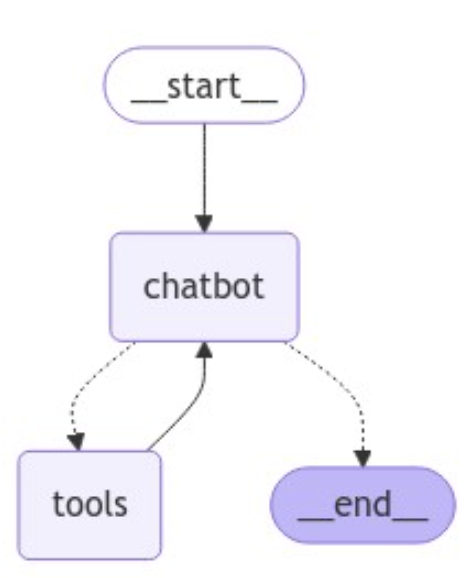
Fuente: [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements)

<h3> Descripción del agente investigativo </h3>

El agente investigativo que construiremos en este taller es un sistema autónomo diseñado para ayudar en tareas de investigación, especialmente en el ámbito académico y científico. Este agente combina múltiples herramientas y fuentes de información para recopilar, analizar y presentar datos de manera estructurada y útil. A continuación, se detallan sus funcionalidades y características principales.

El agente estará compuesto por las siguientes herramientas y capacidades:


1. ArXiv Paper Fetch:

    - Descripción: Dado un ID de un artículo de arXiv, el agente puede obtener el resumen y los metadatos del artículo.

    - Uso: Ideal para acceder rápidamente a información específica de un paper sin necesidad de navegar manualmente por arXiv.

2. Búsqueda en la Web:

    - Descripción: El agente puede realizar búsquedas en Google para consultas generales o para complementar la información obtenida de otras fuentes.

    - Uso: Útil para encontrar información actualizada o contextual que no esté disponible en arXiv.

3. Búsqueda RAG (Retrieval-Augmented Generation):

    - Descripción: El agente tiene acceso a una base de conocimientos local que contiene artículos de arXiv sobre IA. Puede realizar búsquedas en esta base para obtener información relevante.

    - Uso: Permite al agente acceder a un repositorio estructurado de conocimiento especializado.

4. Búsqueda RAG con Filtro:

    - Descripción: Cuando el agente necesita información más detallada de un artículo específico, puede realizar una búsqueda filtrada dentro de la base de conocimientos.

    - Uso: Facilita la obtención de detalles específicos, como secciones concretas de un paper o datos técnicos.

5. Respuesta Final:

    - Descripción: El agente utiliza una herramienta personalizada para presentar la información recopilada en un formato específico y fácil de entender.

    - Uso: Garantiza que la información se presente de manera clara y estructurada, siguiendo un formato predefinido.

<h2> Introducción a RAG (Retrieval-Augmented Generation) </h2>

RAG (Retrieval-Augmented Generation) es un enfoque híbrido que combina la recuperación de información (retrieval) con la generación de texto (generation) para mejorar la capacidad de los modelos de lenguaje en tareas que requieren acceso a conocimientos externos. A continuación, se presenta una introducción detallada a RAG y su relevancia en la construcción de agentes investigativos.

RAG es un modelo desarrollado por Facebook AI (ahora Meta AI) que integra dos componentes principales:

- Retrieval (Recuperación): Busca información relevante en una base de conocimientos externa (por ejemplo, una colección de documentos, artículos o bases de datos).

- Generation (Generación): Utiliza un modelo de lenguaje (como GPT) para generar respuestas basadas en la información recuperada.

La combinación de estos dos componentes permite a RAG proporcionar respuestas más precisas y contextualizadas, especialmente en tareas que requieren acceso a información específica o actualizada.

El proceso de RAG se divide en tres pasos principales:

- Recuperación de Información: Dada una consulta, el sistema busca en una base de conocimientos (por ejemplo, una colección de artículos de arXiv) para encontrar documentos o pasajes relevantes. Esto se hace utilizando técnicas de búsqueda semántica, como la comparación de embeddings (vectores de palabras o frases) para encontrar coincidencias contextuales.

- Fusión de Contexto: La información recuperada se combina con la consulta original para proporcionar un contexto enriquecido al modelo de generación.

- Generación de Respuesta: El modelo de lenguaje genera una respuesta basada en la consulta y el contexto recuperado. Esto permite respuestas más informadas y precisas.

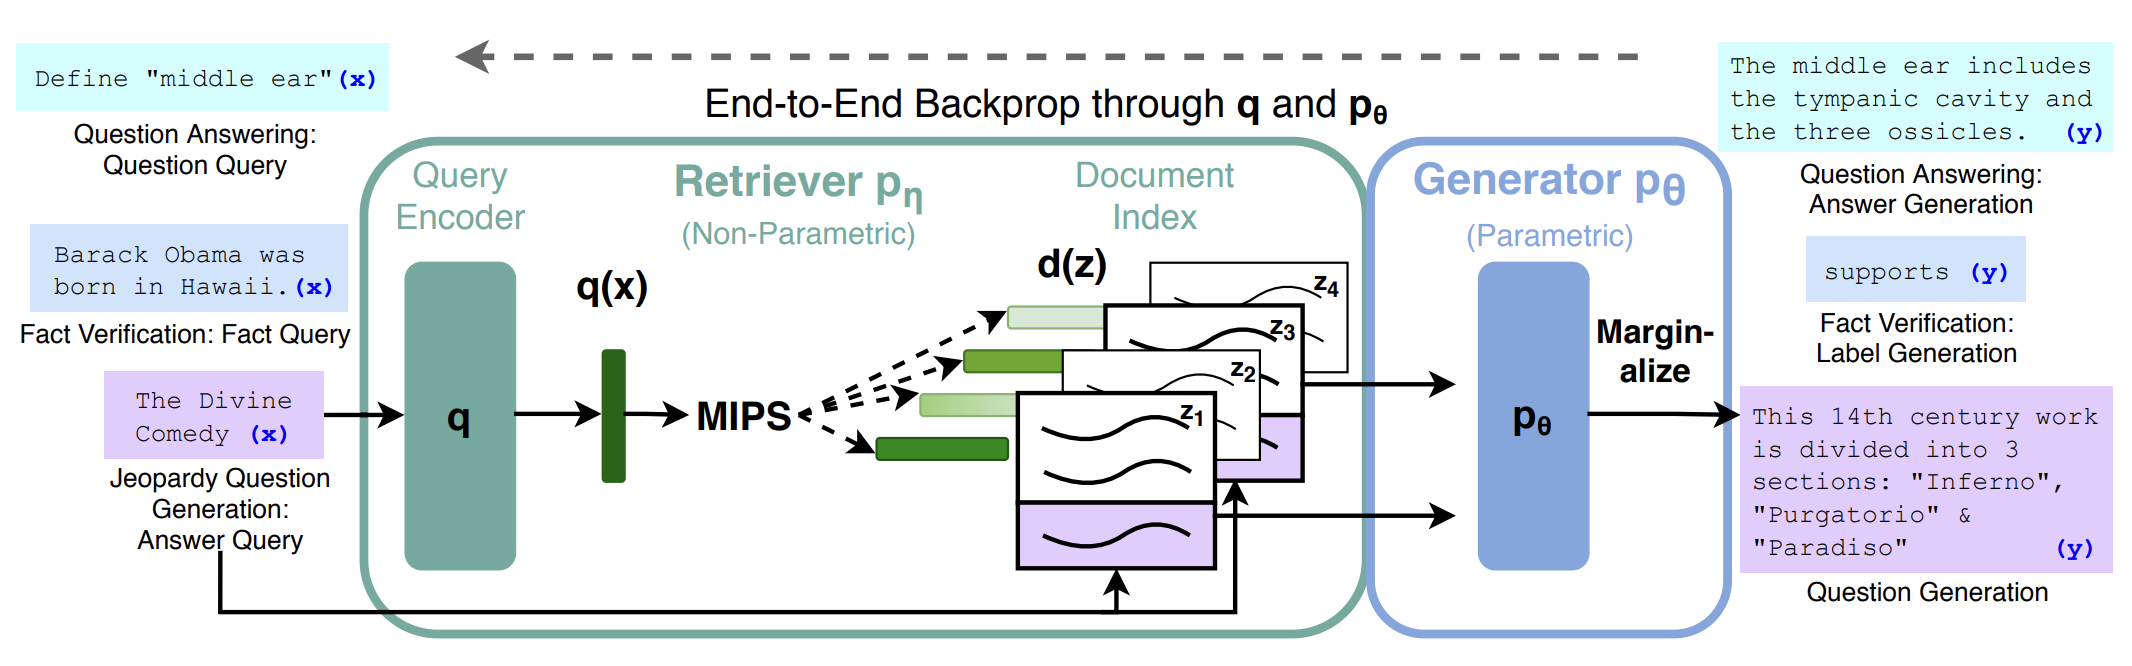

Fuente: [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks](https://arxiv.org/pdf/2005.11401)

<h3> Ventajas de RAG </h3>

- Acceso a Conocimientos Externos: RAG permite a los modelos de lenguaje acceder a información actualizada o específica que no está incluida en su entrenamiento original.

- Precisión Mejorada: Al basarse en información recuperada de fuentes confiables, las respuestas generadas son más precisas y relevantes.

- Flexibilidad: RAG puede adaptarse a diferentes bases de conocimientos, lo que lo hace útil para una variedad de aplicaciones (investigación, soporte técnico, etc.).

- Transparencia: Al recuperar información de fuentes específicas, es posible rastrear el origen de la información utilizada para generar la respuesta.

<h2> El concepto de Agente </h2>

En el contexto de LangGraph, un Agente es una entidad inteligente que responde a las instrucciones del usuario (prompts) y dispone de herramientas (tools) para realizar acciones específicas. Su función principal es decidir, en cada etapa del razonamiento, si responde directamente o si delega en una herramienta para obtener información o procesarla antes de contestar.

Interfaz conversacional: El Agente recibe un texto (la pregunta del usuario) y produce un texto de respuesta.
Capacidad de razonamiento: Internamente, el Agente sigue un “flujo de pensamiento” que lo lleva a decidir si utilizar alguna herramienta o proporcionar la respuesta final.
Uso de herramientas: Si el Agente no tiene suficiente información, puede recurrir a un conjunto de funciones especializadas (por ejemplo, búsquedas en internet, scraping de una web científica o consultar un repositorio de conocimiento).

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
# from dotenv import load_dotenv
# import os

In [ ]:
# load_dotenv('.env')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

#### Para OpenAI:
#from langchain_openai import ChatOpenAI
#llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

##### Para Anthropic:
# from langchain_anthropic import ChatAnthropic
# llm = ChatAnthropic(model="claude-3-haiku-20240307")

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

En **LangGraph**, los *nodes* representan unidades de procesamiento (por ejemplo, un prompt o una herramienta) dentro de un flujo de trabajo, mientras que los *edges* representan las conexiones entre esos *nodes*, indicando el orden o la lógica de cómo fluye la información. Así, los *nodes* contienen la lógica principal de una operación —como una consulta a una base de datos, la ejecución de un modelo de lenguaje o la lectura de un documento—, y los *edges* definen el camino que llevan los datos desde un paso hasta el siguiente, otorgando la estructura necesaria para crear cadenas complejas de razonamiento y acción.

In [ ]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

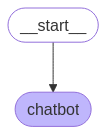

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [ ]:
while True:
    query = input('Usuario:')

    if query == 'q':
        break

    stream_graph_updates(query)

## La arquitectura ReAct

En esta sección, construiremos un agente de IA utilizando la arquitectura ReAct (Reasoning and Acting). ReAct es un marco para estructurar el proceso de resolución de problemas de un LLM (Large Language Model), imitando patrones cognitivos humanos:

1. **Reason** sobre la situación actual
2. **Decide** la acción a tomar
3. **Observe** los resultados de esa acción
4. **Repeat** hasta que la tarea esté completa

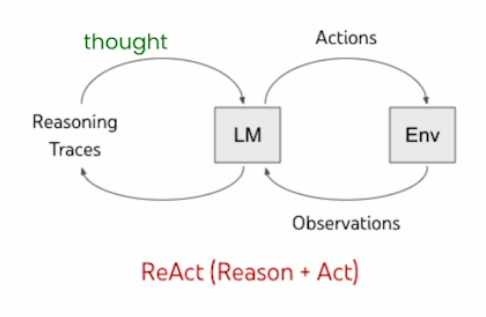

Para ilustrar este concepto, considera cómo un ingeniero de software experimentado podría abordar la depuración de un sistema complejo:

1. **Reason**: Analizar los registros de errores y el estado del sistema (por ejemplo, "La conexión a la base de datos está agotando el tiempo de espera")
2. **Act**: Implementar una acción de diagnóstico (por ejemplo, "Ejecutar una prueba de conexión a la base de datos")
3. **Observe**: Examinar los resultados del diagnóstico (por ejemplo, "La prueba muestra una latencia alta")
4. **Repeat**: Continuar con este proceso, tal vez revisando las configuraciones de red a continuación, hasta que se resuelva el problema

Nuestro agente de IA empleará una metodología similar para abordar problemas. A medida que desarrollemos este agente, haremos la división del trabajo entre el modelo de IA (el "cerebro" que razona y decide) y nuestro código en Python (el "cuerpo" que interactúa con el entorno y gestiona el flujo del proceso).

Este notebook está basado en el siguiente [notebook de James Briggs](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb).

<h2> Agente de Investigación con LangGraph </h2>

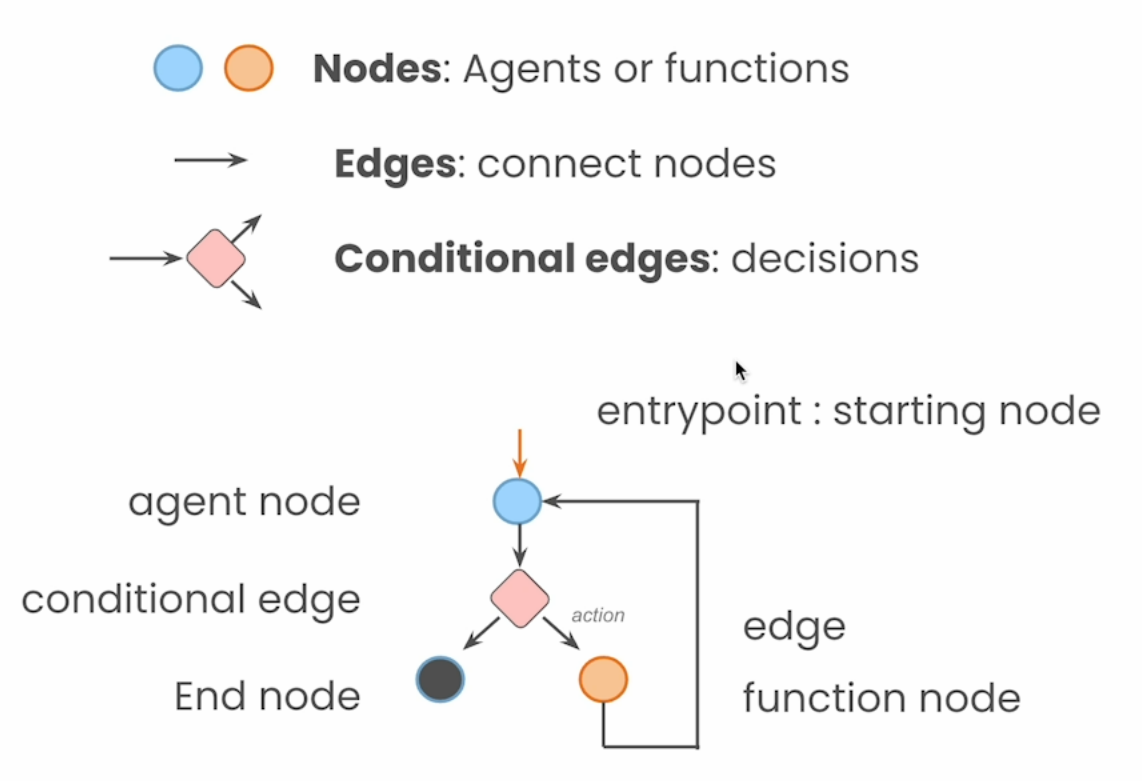

<h3> Herramientas (Tools) </h3>

Una herramienta es una abstracción que LangGraph define con el fin de:

- Acceder a fuentes externas: Buscar información en internet, hacer scraping de sitios web, interactuar con APIs, consultar bases de datos, etc.
- Procesar información especializada: Analizar PDFs, convertir formatos, ejecutar análisis numéricos o estadísticos.
- Simplificar la integración: Ofrecer una interfaz unificada para que el modelo de lenguaje no tenga que “saber” cómo funciona la API o servicio subyacente; simplemente invoca la herramienta y recibe un resultado.

El objetivo es permitir que el LLM delegue tareas prácticas y enfocarse en el razonamiento e integración final de la información.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
tool = TavilySearchResults(max_results=3)
tools = [tool]
tool.invoke("¿Para qué sirve LangGraph?")

In [ ]:
from langchain_core.tools import tool

In [ ]:
# Definan las funciones que deseen y prueben la ejecución de las mismas a través de lenguaje natural

@tool
def sumar(a: float, b: float ) -> float:
    """
    Función para sumar dos números a y b
    """
    return a + b

@tool
def multiplicar(a: float, b: float) -> float:
    """
    Función para multiplicar dos números a y b
    """
    return a * b

In [ ]:
tools.append(sumar)
tools.append(multiplicar)

In [ ]:
tools

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
while True:
    query = input('Usuario:')

    if query == 'q':
        break

    print(llm_with_tools.invoke(query))
    print('=======================')

<h3> Descripción general del agente de investigación </h3>

Nuestro agente de investigación consistirá en un agente de IA que llama funciones y tiene acceso a varias herramientas que puede usar para encontrar información sobre un tema en particular. Podrá usar varias herramientas a lo largo de múltiples pasos, lo que significa que puede encontrar información sobre un tema, ampliar el alcance del conocimiento sobre ese tema e _incluso_ investigar temas paralelos donde sea relevante.

Las herramientas que utilizaremos son:

* **ArXiv paper fetch**: Dado un ID de un artículo de arXiv, esta herramienta proporciona a nuestro agente el resumen del artículo.
* **Búsqueda en la web**: Esta herramienta proporciona a nuestro agente acceso a la búsqueda en Google para consultas más generales.
* **Búsqueda RAG**: Crearemos una base de conocimientos que contendrá artículos de arXiv sobre IA. Esta herramienta proporciona a nuestro agente acceso a este conocimiento.
* **Búsqueda RAG con filtro**: A veces nuestro agente puede necesitar más información de un artículo específico, esta herramienta permite a nuestro agente hacer justamente eso.
* **Respuesta final**: Crearemos una herramienta personalizada de respuesta final que obliga a nuestro agente a presentar la información en un formato específico como:

```
INTRODUCCIÓN
------------
<alguna introducción a nuestro informe>

PASOS DE INVESTIGACIÓN
----------------------
<los pasos que el agente siguió durante la investigación>

INFORME
-------
<cuerpo principal del informe>

CONCLUSIÓN
----------
<la conclusión del informe>

FUENTES
-------
<cualquier fuente que el agente haya utilizado>
```
```

En este notebook desarrollaremos un **Agente de investigación**. Este es un agente multistep que, a través de varias etapas (steps), puede producir informes de investigación detallados sobre un tema de nuestra elección. La mayoría de los agentes de investigación están integrados en sus propios frameworks, como [Scite_AI](https://scite.ai/), [BlockAGI](https://github.com/orgexyz/BlockAGI), [GPT Researcher](https://github.com/assafelovic/gpt-researcher) y otros.

En este ejemplo, demostraremos cómo podemos construir nuestro propio agente de investigación de IA utilizando `gpt-4o` y `gpt-4o-mini`, Pinecone, LangGraph, arXiv y Google a través de SerpAPI.


<h3> Definición de estados del grafo </h3>

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str ## representa la entrada actual
    chat_history: list[BaseMessage] ## mantiene un registro de la conversación pasada
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add] ##  permite rastrear las acciones intermedias o previas del agente

Nuestro estado de agente tiene cuatro partes, que son:

* `input`: esta es la consulta más reciente del usuario, generalmente sería una pregunta que queremos responder con nuestro agente de investigación.
* `chat_history`: estamos construyendo un agente conversacional que puede soportar múltiples interacciones. Para permitir que las interacciones anteriores proporcionen contexto adicional a lo largo de la lógica del agente, incluimos el historial de chat en el estado del agente.
* `intermediate_steps`: proporciona un registro de todos los pasos que tomará el agente de investigación entre que el usuario hace una pregunta a través de `input` y el agente proporciona una respuesta final. Esto puede incluir cosas como "buscar en arxiv", "realizar búsqueda general en la web", etc. Estos pasos intermedios son para permitir que el agente siga un camino de acciones coherentes y, finalmente, produzca una respuesta final informada.


<h3> Definición de las herramientas `(Tools)`</h3>

<h4> Búsqueda de papers en arxiv </h4>

Usemos como ejemplo el artículo https://export.arxiv.org/abs/2210.03629

In [ ]:
import requests

# Hacemos un test con el paper "ReAct: Synergizing Reasoning and Acting in Language Models"
arxiv_id = "2210.03629"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
# res.text
res.text.split("\n")

['<?xml version="1.0" encoding="UTF-8"?>',
 '<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">',
 '<html xmlns="http://www.w3.org/1999/xhtml" lang="en">',
 '<head>',
 '<title>[2210.03629] ReAct: Synergizing Reasoning and Acting in Language Models</title>',
 '<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />',
 '<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />',
 '<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">',
 '<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />',
 '<meta name="citation_title" content="ReAct: Synergizing Reasoning and Acting in Language Models" />',
 '<meta name="citation_author" content="Yao, Shunyu" />',
 '<meta name="citation_author" content="Zhao, Jeffrey" />',
 '<meta name="citation_author" content="Yu, Dian" />',
 '<m

In [ ]:
import re

# Nuestra regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# Hacemos la busqueda
re_match = abstract_pattern.search(res.text)

# imprimimos el texto extraido
print(re_match.group(1))

While large language models (LLMs) have demonstrated impressive capabilities
across tasks in language understanding and interactive decision making, their
abilities for reasoning (e.g. chain-of-thought prompting) and acting (e.g.
action plan generation) have primarily been studied as separate topics. In this
paper, we explore the use of LLMs to generate both reasoning traces and
task-specific actions in an interleaved manner, allowing for greater synergy
between the two: reasoning traces help the model induce, track, and update
action plans as well as handle exceptions, while actions allow it to interface
with external sources, such as knowledge bases or environments, to gather
additional information. We apply our approach, named ReAct, to a diverse set of
language and decision making tasks and demonstrate its effectiveness over
state-of-the-art baselines, as well as improved human interpretability and
trustworthiness over methods without reasoning or acting components.
Concretely, on 

Construimos la herramienta

In [ ]:
from langchain_core.tools import tool
import requests
import re

## Búsqueda de papers en ArXiv
@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Obtiene el abstract de un artículo de ArXiv dado el ID de arxiv. Útil para
    encontrar contexto de alto nivel sobre un artículo específico."""

    ## Regex del abstract
    abstract_pattern = re.compile(
        r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
        re.DOTALL
    )

    # trae la pagina del paper en html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )

    # busca el html del abstract
    re_match = abstract_pattern.search(res.text)

    # retorna el abstract del articulo
    return re_match.group(1)

Prueba de la herramienta

In [ ]:
# Vamos a hacer un test con el paper de Mixtral
arxiv_id = "2401.04088"

print(fetch_arxiv.invoke(input={"arxiv_id": arxiv_id}))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


<h4> Web Search </h4>

In [ ]:
# import serpapi
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": SERPAPI_API_KEY
    }

**Web Search con Tavily**

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""

    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(query)

    return search_docs

In [ ]:
query = "Qué es LangGraph?"
web_search(query)

<ipython-input-34-5a4270b16f70>:2: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  web_search(query)


[{'title': 'LangGraph - LangChain',
  'url': 'https://www.langchain.com/langgraph',
  'content': "Build and scale agentic applications with LangGraph Platform. Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastructure built for agents. LangGraph sets the foundation for how we can build and scale AI workloads — from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution to iterate quickly, debug immediately, and scale effortlessly.” LangGraph sets the foundation for how we can build and scale AI workloads — from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. LangGraph Platform is a service for deploying and scaling LangGraph applications, with an opinionated 

**Web search con serpAPI**

In [ ]:
@tool("web_search_serp")
def web_search_serp(query: str):
    """Encuentra información de conocimientos generales mediante la búsqueda de Google. También se puede utilizar
    para ampliar conocimientos más "generales" a una consulta especializada previa."""
    # client = serpapi.Client(api_key=SERPAPI_API_KEY)

    # results = client.search({
    #     'engine': 'google',
    #     'q': query
    # })

    # results = results.data['organic_results']

    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 10 ## Número de resultados
    })

    results = search.get_dict()["organic_results"]

    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )

    return contexts

In [ ]:
# client = serpapi.Client(api_key=SERPAPI_API_KEY)
# results = client.search({
#     'engine': 'google',
#     'q': '¿Qué es langchain?',
#     'engine': 'google'
# })

query = "Qué es Tensor Flow Colombia?"
print(web_search_serp(query))

Comienza a usar TensorFlow
Una plataforma de extremo a extremo de código abierto, enfocada en el aprendizaje automático, para todos. Descubre el ecosistema flexible de herramientas, ...
https://www.tensorflow.org/?hl=es-419
---
TensorFlow: precios, funciones y opiniones
TensorFlow es una plataforma de código abierto que ayuda a los desarrolladores, empresas e investigadores a crear, lanzar y gestionar aplicaciones con ML ( ...
https://www.getapp.com.co/software/125283/tensorflow
---
TensorFlow
TensorFlow makes it easy to create ML models that can run in any environment. Learn how to use the intuitive APIs through interactive code samples.
https://www.tensorflow.org/
---
TensorFlow en Machine Learning: qué es y cómo funciona
TensorFlow se utiliza principalmente para crear y entrenar redes neuronales, que luego pueden emplearse en tareas como la clasificación de imágenes, la ...
https://www.eaebarcelona.com/es/blog/tensorflow
---
¿Qué es TensorFlow y para qué sirve? - Incentro
TensorFlow

<h4> RAG tools </h4>

Definimos el encoder que vamos a utilizar

sk-svcacct-DXapCp-UErhiiahQWKW0zGCXp_QMe-WQpI6J_6NmQDJzEmGlG4VBRKWWPnuF8VyT3BlbkFJIjzqO45ON60v_U16dB14N-qYz2RvHCtDmynlvSIm6jFKd5MZaVvctmYsS4qoOAA

In [ ]:
import semantic_router

In [ ]:
from semantic_router.encoders import OpenAIEncoder
import openai

openai.api_key = OPENAI_API_KEY
encoder = OpenAIEncoder(name="text-embedding-3-small")
# encoder = OpenAIEncoder(name="text-embedding-3-large")

In [ ]:
dims = len(encoder(["Texto aleatorio para mirar dimension de los vectores"])[0])
dims

ERROR:semantic_router.utils.logger:Exception occurred
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/semantic_router/encoders/openai.py", line 140, in __call__
    embeds = self._client.embeddings.create(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/openai/resources/embeddings.py", line 128, in create
    return self._post(
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/openai/_base_client.py", line 1242, in post
    return cast(ResponseT, self.request(cast_to, opts, stream=stream, stream_cls=stream_cls))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/openai/_base_client.py", line 919, in request
    return self._request(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/openai/_base_client.py", line 1023, in _request
    raise self._make_status_error_from_respons

PermissionDeniedError: Error code: 403 - {'error': {'message': 'Project `proj_gtt1JzvQCtG10u8oJvHoAvA6` does not have access to model `text-embedding-3-small`', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

Inicializamos Pinecone Client

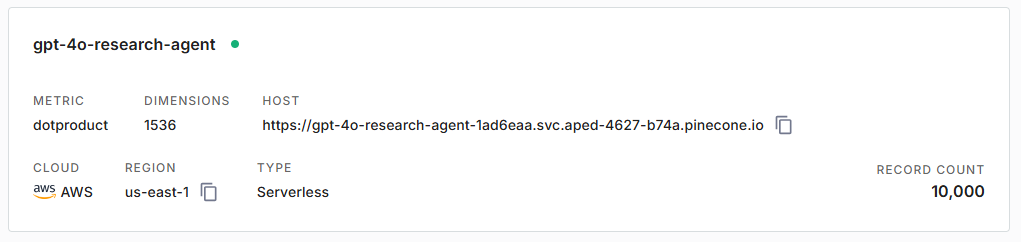

#### Setup Knowledge Base - Abstracts de Arxiv vectorizados en Pinecone

In [ ]:
from pinecone import Pinecone

# configure client
pc = Pinecone(api_key=PINECONE_API_KEY)

Conectamos con los index disponibles en pinecone

In [ ]:
index_name = "gpt-4o-research-agent"

# connect to index
index = pc.Index(index_name)

# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

#### Definición de los tools para el RAG

Construimos dos herramientas centradas en RAG para nuestro agente:
- La función `rag_search` permite al agente realizar una búsqueda RAG simple de información en _todos_ los artículos de investigación indexados. La función `rag_search_filter` también realiza búsquedas, pero _dentro_ de un artículo específico que se filtra a través del parámetro `arxiv_id`.

- También definimos la función `format_rag_contexts` para manejar la transformación de nuestros resultados de Pinecone de un objeto JSON a un formato de texto simple legible.

In [ ]:
from langchain_core.tools import tool

# Definimos una función auxiliar llamada 'format_rag_contexts' que recibe una lista de coincidencias 'matches'.
# Esta función toma cada coincidencia y extrae datos clave, como el título, contenido, ID de ArXiv y referencias relacionadas.
# Luego, formatea esta información en un bloque de texto estructurado y lo agrega a una lista de contextos 'contexts'.
# Finalmente, convierte esta lista en una sola cadena de texto 'context_str', donde cada contexto está separado por "---".
def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Content: {x['metadata']['content']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
            f"Related Papers: {x['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str


In [ ]:
# Definimos una herramienta 'rag_search_filter' con el decorador @tool para integrarla en LangGraph o LangChain.
# Esta herramienta permite buscar información en una base de datos de ArXiv utilizando una consulta en lenguaje natural y un ID específico de ArXiv.
# La función recibe dos parámetros: 'query' que es la consulta de búsqueda, y 'arxiv_id' que es el ID del artículo específico.
# Dentro de la función, codificamos la consulta con el 'encoder' y realizamos una consulta en el 'index' usando el ID de ArXiv como filtro.
# La respuesta se procesa con la función 'format_rag_contexts' para crear un contexto formateado, el cual se retorna al final.
@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Busca información en nuestra base de datos de ArXiv utilizando una consulta en lenguaje natural
    y un ID específico de ArXiv. Esto nos permite obtener más detalles sobre un artículo específico."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str


In [ ]:
# Definimos otra herramienta llamada 'rag_search', también decorada con @tool.
# Esta herramienta permite buscar información especializada en IA usando solo una consulta en lenguaje natural.
# La función toma un solo parámetro 'query', que es la consulta de búsqueda.
# Codificamos la consulta y realizamos una búsqueda en el 'index', esta vez sin aplicar filtros específicos.
# Solo seleccionamos las dos mejores coincidencias (top_k=2) para reducir la información.
# Nuevamente, procesamos la respuesta con 'format_rag_contexts' para retornar un contexto formateado.
@tool("rag_search")
def rag_search(query: str):
    """Busca información especializada en IA usando una consulta en lenguaje natural."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=2, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str

<h4> Tool para generar formato de respuesta del agente </h4>

Esta no es propiamente una herramienta en el sentido habitual, sino que la utilizamos para forzar un formato de salida específico desde nuestro LLM a través de la llamada a la función/herramienta.

In [ ]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Devuelve una respuesta en lenguaje natural al usuario en forma de un informe
    de investigación. Este informe incluye varias secciones, que son:

    - `introduction`: un párrafo corto que introduce la pregunta del usuario y el
      tema que estamos investigando.
    - `research_steps`: una lista de puntos que explica los pasos que se tomaron
      para investigar el informe.
    - `main_body`: aquí se incluye la mayor parte de la información de alta calidad
      y concisa que responde a la pregunta del usuario. Debe tener entre 3-4 párrafos.
    - `conclusion`: un párrafo breve que proporciona una conclusión concisa pero
      sofisticada sobre los hallazgos.
    - `sources`: una lista de fuentes detalladas en forma de puntos, que incluye
      todas las referencias utilizadas durante el proceso de investigación.
    """

    # Si 'research_steps' es una lista, la convierte en una cadena formateada con viñetas.
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])

    # Si 'sources' es una lista, también la convierte en una cadena con viñetas.
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])

    return ""


<h3> Inicialización del agente (LLM) </h3>

Creamos el system prompt con el comportamiento deseado para el agente. Este prompt establecerá la capacidad de toma de decisiones del agente dentro del `system_prompt`, dejará un marcador de posición para que luego insertemos `chat_history` y nos proporcionará un lugar para insertar la `input` del usuario.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """Eres un Investigador Senior, eres un excelente tomador de decisiones.
Ante la consulta del usuario debes decidir qué hacer con ella en función de la
lista de herramientas que se te proporcionan.

Si ves que se ha utilizado una herramienta (en el scratchpad) con un propósito particular de
consulta, NO utilices esa misma herramienta con la misma consulta nuevamente. Además, NO utilices
cualquier herramienta más de dos veces (es decir, si la herramienta aparece en el scratchpad dos veces,
no volver a usarla).

Debes intentar recopilar información de una amplia gama de fuentes antes de
proporcionar la respuesta al usuario. Una vez que hayas recopilado mucha información
para responder la pregunta del usuario (almacenada en el scratchpad) usa la herramienta final_answer."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

A continuación, debemos inicializar nuestro `llm` (para esto usamos `gpt-4o-mini`) y luego crear el pipeline _ejecutable_ de nuestro agente investIgAdor.

In [ ]:
from langchain_core.messages import ToolCall, ToolMessage

In [ ]:
# Lista de herramientas que el modelo podrá utilizar
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    web_search_serp,
    final_answer
]

El ejecutable conecta nuestras entradas (el `input` del usuario y `chat_history`) a nuestro `prompt`, y nuestro `prompt` a nuestro `llm`. También es donde _vinculamos_ nuestras herramientas al LLM y aplicamos la llamada a funciones a través de `tool_choice="any"`.

In [ ]:
## Función para transformar los pasos intermedios en un "scratchpad" de texto
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":  # Solo agrega los pasos que ya se han ejecutado
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

# Configuración del flujo de datos para el agente de IA, incluyendo el uso de herramientas
researcher = (
    {
        # Extrae el valor de entrada (input) desde el diccionario 'x'.
        # Esto se usará como la consulta inicial que recibe el agente de IA.
        "input": lambda x: x["input"],

        # Extrae el historial de chat desde 'x', permitiendo que el modelo mantenga contexto.
        "chat_history": lambda x: x["chat_history"],

        # Usa la función 'create_scratchpad' para procesar los pasos intermedios
        # de investigación ('intermediate_steps') y los convierte en un "scratchpad".
        # Esto sirve como un registro de todas las herramientas usadas y sus resultados,
        # permitiendo al modelo a comprender el proceso previo y evitar repeticiones.
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    # Se combina con el 'prompt'. Esto añade instrucciones al agente.
    | prompt

    # 'bind_tools' conecta las herramientas listadas en 'tools' al modelo (LLM),
    # permitiéndole elegir y utilizar cualquier herramienta que necesite para completar su tarea.
    | llm.bind_tools(tools, tool_choice="any")
)


Probamos el agente para validar su funcionamiento

In [ ]:
inputs = {
    "input": "cuentame acerca de DevOpsDay Bogota",
    "chat_history": [],
    "intermediate_steps": [],
}

output = researcher.invoke(inputs)
output

AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "DevOpsDays Bogota"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-057bbde4-f9a2-406d-8b4d-519e2d60e941-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'DevOpsDays Bogota'}, 'id': 'fcb38885-4b6d-411b-8a0a-ac3e102be5d2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 556, 'output_tokens': 8, 'total_tokens': 564, 'input_token_details': {'cache_read': 0}})

Al ejecutar el agente retornamos una gran cantidad de metadatos. Por esto, podemos limitarlos a lo que necesitamos, es decir, el nombre de la herramienta elegida y los argumentos de entrada generados para la herramienta.

In [ ]:
output.tool_calls[0]["name"]

'web_search'

In [ ]:
output.tool_calls[0]["args"]

{'query': 'DevOpsDays Bogota'}

Como se observa, nuestro `Researcher` decidió utilizar la herramienta `web_search` con la `consulta`: `"DevOpsDay Bogota 2023"`.

## Definimos los nodos del grafo del agente

Pasaremos la decisión de uso de la herramienta a nuestro `enrutador`, que _enrutará_ la salida al componente de nodo elegido para ejecutar (los definimos a continuación) en función del valor `output.tool_calls[0]["name"]`.

In [ ]:
from langchain_core.prompts.chat import BaseMessage

def run_researcher(state: list):
    # Imprime el mensaje inicial y el contenido actual de 'intermediate_steps' en el estado
    print("run_researcher")
    print(f"intermediate_steps: {state['intermediate_steps']}")

    # Ejecuta el agente 'Researcher' con el estado actual como parámetro
    output = researcher.invoke(state)

    # Extrae el nombre y argumentos de la herramienta usada en 'output'
    tool_name = output.tool_calls[0]["name"]
    tool_args = output.tool_calls[0]["args"]

    # Crea un objeto 'AgentAction' con la herramienta, su entrada y un log pendiente ("TBD")
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )

    # Devuelve el estado actualizado con el nuevo paso intermedio
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # Determina el nombre de la herramienta a usar según el último paso en 'intermediate_steps'
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # Si el formato es inválido, redirige a la herramienta "final_answer"
        print("Router invalid format")
        return "final_answer"

Todas las herramientas se pueden ejecutar utilizando la misma lógica de función, que definimos con `run_tool`. Los parámetros de entrada para la llamada a nuestra herramienta y el resultado obtenido se agregan al parámetro `intermediate_steps` del estado de nuestro grafo.

In [ ]:
# Diccionario que asigna nombres de herramientas a sus funciones correspondientes
tool_str_to_func = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "web_search_serp": web_search_serp,
    "final_answer": final_answer
}

def run_tool(state: list):
    # Obtiene el nombre de la herramienta y sus argumentos desde el último paso en 'intermediate_steps'
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")  # Muestra la llamada de la herramienta con sus argumentos

    # Ejecuta la herramienta correspondiente usando el diccionario 'tool_str_to_func'
    output = tool_str_to_func[tool_name].invoke(input=tool_args)

    # Crea un nuevo objeto 'AgentAction' con la herramienta, su entrada, y el resultado obtenido
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(output)
    )

    # Devuelve el estado actualizado con el nuevo paso intermedio que incluye el resultado
    return {"intermediate_steps": [action_out]}


In [ ]:
from langgraph.graph import StateGraph, END

# Crea un grafo de estado (StateGraph) que maneja el estado del agente
graph = StateGraph(AgentState)

# Añade nodos al grafo, cada uno representando una herramienta o función
graph.add_node("researcher", run_researcher)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("web_search_serp", run_tool)
graph.add_node("final_answer", run_tool)

# Define el punto de entrada del grafo, donde comienza la ejecución
graph.set_entry_point("researcher")

# Agrega edges condicionales para decidir qué nodo seguir desde el "Researcher"
# Utiliza la función 'router' para determinar cuál es el próximo nodo a ejecutar
graph.add_conditional_edges(
    source="researcher",
    path=router,
)

# Crea conexiones de cada herramienta de vuelta al "Researcher", excepto "final_answer"
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "researcher")

# Si se llega a "final_answer", el flujo del grafo se dirige al nodo final 'END'
graph.add_edge("final_answer", END)

# Compila el grafo para hacerlo ejecutable
runnable = graph.compile()

In [ ]:
from IPython.display import Image, display

# Visualizar el grafo del Agente
display(Image(runnable.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

## Funcion para generar el reporte final del agente

In [ ]:
output = runnable.invoke({
    "input": "Investiga acerca de DevOpsDay en Bogotá",
    "chat_history": [],
})

run_researcher
intermediate_steps: []
web_search.invoke(input={'query': 'DevOpsDays Bogotá'})
run_researcher
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'DevOpsDays Bogotá'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'DevOpsDays Bogotá'}, log="[{'title': 'Devops Days Bogotá: HOME', 'url': 'https://devopsdaysbogota.org/', 'content': 'DevOpsDays es un evento internacional de conferencias técnicas sobre temas de desarrollo de software, operaciones de TI y la intersección entre ellas. Asiste a', 'score': 0.9304142}, {'title': 'devopsdays Bogotá 2024', 'url': 'https://devopsdays.org/events/2024-bogota/welcome/', 'content': '¡DevOpsDays Bogotá es el evento por excelencia para compartir con entusiastas y expertos en DevOps y conocer las mejores practicas, marcos de', 'score': 0.9291904}, {'title': 'DevOpsDays Bogotá 2023', 'url': 'https://devopsdays.org/events/2023-bogota/welcome/', 'content': 'El evento principal de DevOps en Colombia DevOps

Definimos una función para consumir la salida del agente y llevarla al formato deseado para el informe:

In [ ]:
def build_report(output: dict):
    # Procesa 'research_steps' para convertirlo en una lista con formato de viñetas, si es necesario
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])

    # Procesa 'sources' para convertirlo en una lista con formato de viñetas, si es necesario
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])

    # Genera y retorna el reporte en formato de texto estructurado
    return f"""
INTRODUCCIÓN
------------
{output["introduction"]}

PASOS DE INVESTIGACIÓN
--------------
{research_steps}

REPORTE
------
{output["main_body"]}

CONCLUCIÓN
----------
{output["conclusion"]}

FUENTES
-------
{sources}
"""


In [ ]:
print(build_report(
    output=output["intermediate_steps"][-1].tool_input
))


INTRODUCCIÓN
------------
DevOpsDays Bogotá es una conferencia técnica que se celebra anualmente en Bogotá, Colombia.

PASOS DE INVESTIGACIÓN
--------------
- Se realizó una búsqueda web sobre "DevOpsDays Bogotá".
- Se revisaron los resultados de búsqueda para recopilar información sobre el evento.

REPORTE
------
DevOpsDays es una serie de conferencias comunitarias mundiales para cualquier persona interesada en la mejora de TI. El evento en Bogotá ofrece una plataforma para que profesionales, líderes de opinión y entusiastas se conecten, compartan conocimientos y mejores prácticas, y fomenten la colaboración dentro de la comunidad DevOps.

El evento generalmente incluye charlas, talleres y oportunidades de networking. Cubre una amplia gama de temas relacionados con DevOps, como automatización, infraestructura como código, entrega continua, monitoreo y observabilidad, y cultura DevOps.

DevOpsDays Bogotá es un evento clave para cualquiera que esté involucrado o interesado en DevOps en

In [ ]:
out = runnable.invoke({
    "input": "Reliza una investigacion sobre finetunnig de LLMs de bajo costo",
    "chat_history": []
})

run_researcher
intermediate_steps: []
web_search.invoke(input={'query': 'Low cost fine-tuning of LLMs'})
run_researcher
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'Low cost fine-tuning of LLMs'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'Low cost fine-tuning of LLMs'}, log='[{\'title\': \'How to Fine-Tune a 6 Billion Parameter LLM for Less Than $7\', \'url\': \'https://www.anyscale.com/blog/how-to-fine-tune-and-serve-llms\', \'content\': \'In part 4 of our Generative AI series, we share how to build a system for fine-tuning & serving LLMs in 40 minutes or less.\', \'score\': 0.72348577}, {\'title\': \'Fine-Tuning LLMs: A Guide With Examples - DataCamp\', \'url\': \'https://www.datacamp.com/tutorial/fine-tuning-large-language-models\', \'content\': "Learn how fine-tuning large language models (LLMs) improves their performance in tasks like language translation, sentiment analysis, and text generation. In this tutorial, I’ll explain th

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCCIÓN
------------
El ajuste fino de los modelos lingüísticos grandes (LLM) suele ser un proceso costoso. Sin embargo, existen varias estrategias y recursos disponibles para que el ajuste fino sea más asequible.

PASOS DE INVESTIGACIÓN
--------------
- Se realizó una búsqueda web sobre el ajuste fino de LLM de bajo costo.
- Se examinaron los resultados de la búsqueda para recopilar información sobre estrategias y recursos para un ajuste fino rentable.

REPORTE
------
El ajuste fino de los LLM implica adaptar un modelo preentrenado a un conjunto de datos específico, lo que mejora su rendimiento en tareas específicas. Si bien el ajuste fino de modelos grandes puede ser costoso, existen opciones rentables. Anyscale, por ejemplo, permite el ajuste fino de un modelo de 6.000 millones de parámetros por menos de $7. Además, existen marcos de bajo o sin código como LLaMA-Factory que simplifican el proceso de ajuste fino, exportación y servicio de LLM.

Otro factor clave para reducir lo

## Deployment

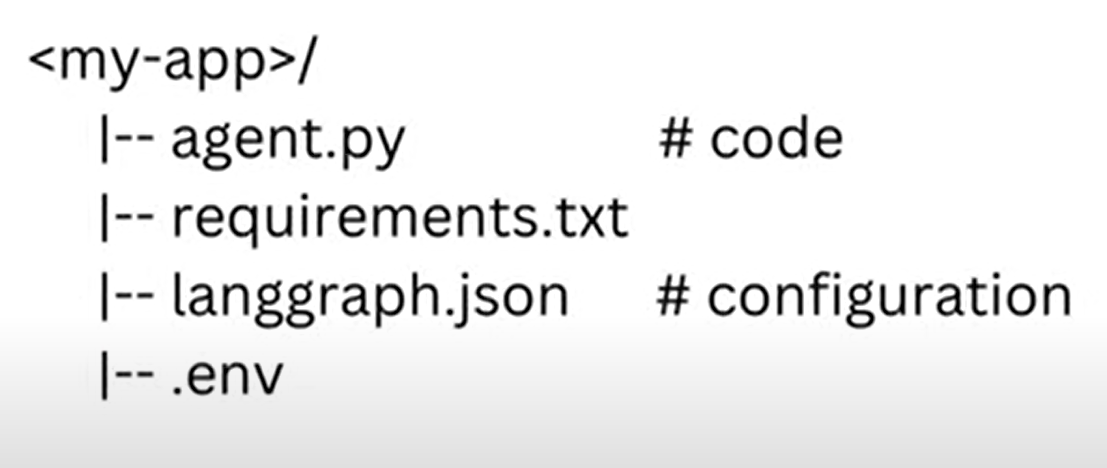